In [1]:
# ================================
# IMPORT LIBRARIES AND SETUP
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from pathlib import Path
import seaborn as sns
import warnings
import os
import pickle
from collections import Counter
from pykalman import KalmanFilter
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import entropy
from scipy.fft import rfft, rfftfreq
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.utils.class_weight import compute_class_weight
import random

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# Set random seeds for reproducibility
np.random.seed(42)

# Create directories for artifacts and visualizations
artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(exist_ok=True)
viz_dir = Path('visualization')
viz_dir.mkdir(exist_ok=True)

os.makedirs(artifacts_dir, exist_ok=True)

print("All libraries imported successfully!")
print(f"Artifacts will be saved in: {artifacts_dir}")
print(f"Visualizations will be saved in: {viz_dir}")

All libraries imported successfully!
Artifacts will be saved in: artifacts
Visualizations will be saved in: visualization


In [2]:
# ================================
# DATA ACQUISITION
# ================================

# Load the TON_IoT door sensor dataset
# Note: Replace 'ton_iot_door_sensor.csv' with your actual file path
df = pd.read_csv(r'D:\Skripsi\Train_Test_datasets\Train_Test_IoT_dataset\Train_Test_IoT_Weather.csv')
print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")

# Display basic information about the dataset
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(df.head(10))
print(f"\nDataset Info:")
print(df.info())
print(f"\nDataset Description:")
print(df.describe())

Dataset loaded successfully!
Dataset shape: (39260, 7)

DATASET OVERVIEW
        date      time  temperature  pressure   humidity  label  type
0  25-Apr-19  17:33:16    40.881866 -0.101806  38.363631      1  ddos
1  25-Apr-19  17:33:16    44.913806  2.661616  46.141423      1  ddos
2  25-Apr-19  17:33:16    38.295822 -2.438871  50.850643      1  ddos
3  25-Apr-19  17:33:21    41.306586 -0.101806  38.363631      1  ddos
4  25-Apr-19  17:33:21    44.903178  3.080849  46.141423      1  ddos
5  25-Apr-19  17:33:21    38.744069 -2.438871  50.850643      1  ddos
6  25-Apr-19  17:33:31    41.507741 -0.551381  36.695085      1  ddos
7  25-Apr-19  17:33:31    44.972845  3.080849  46.890626      1  ddos
8  25-Apr-19  17:33:31    38.987172 -2.438871  46.592192      1  ddos
9  25-Apr-19  17:33:36    41.507741 -0.551381  36.695085      1  ddos

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39260 entries, 0 to 39259
Data columns (total 7 columns):
 #   Column       Non-Null Count  


DATA EXPLORATION
Data Types:
date            object
time            object
temperature    float64
pressure       float64
humidity       float64
label            int64
type            object
dtype: object

Descriptive Statistics:
        temperature      pressure      humidity
count  39260.000000  39260.000000  39260.000000
mean      35.243690      0.834950     47.494834
std        7.981171      3.186265     29.326872
min       20.527012    -12.065426      0.278928
25%       28.903332      0.119504     19.824197
50%       35.909279      1.035000     45.472256
75%       41.396272      1.835559     74.171240
max       49.983877     12.487613     99.875982

Attack type distribution:
type
normal        15000
ddos           5000
backdoor       5000
injection      5000
password       5000
ransomware     2865
xss             866
scanning        529
Name: count, dtype: int64


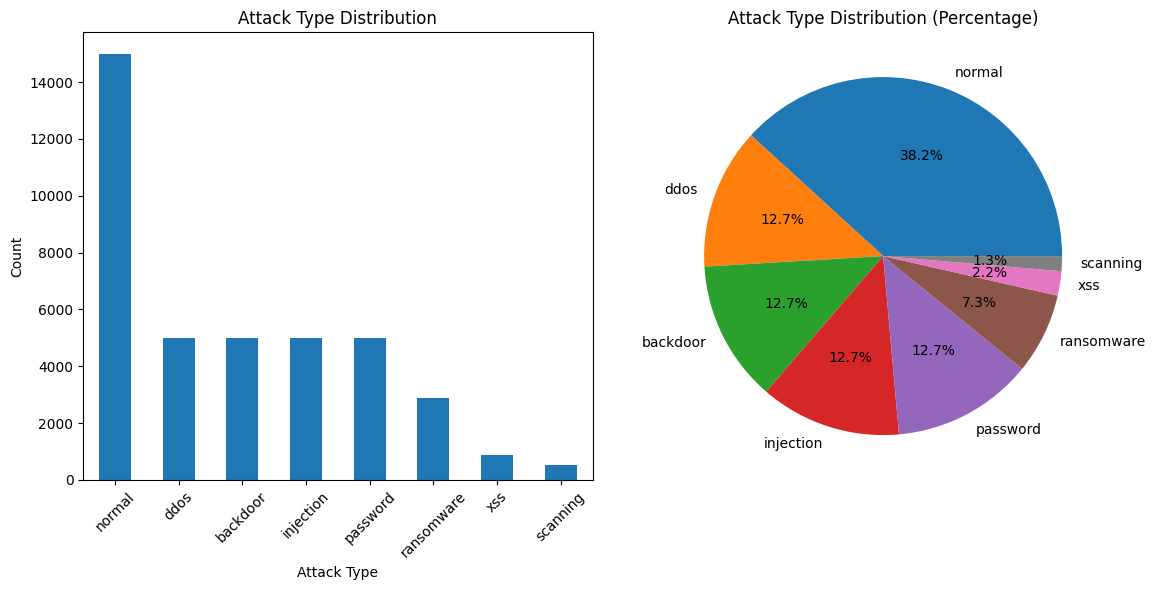

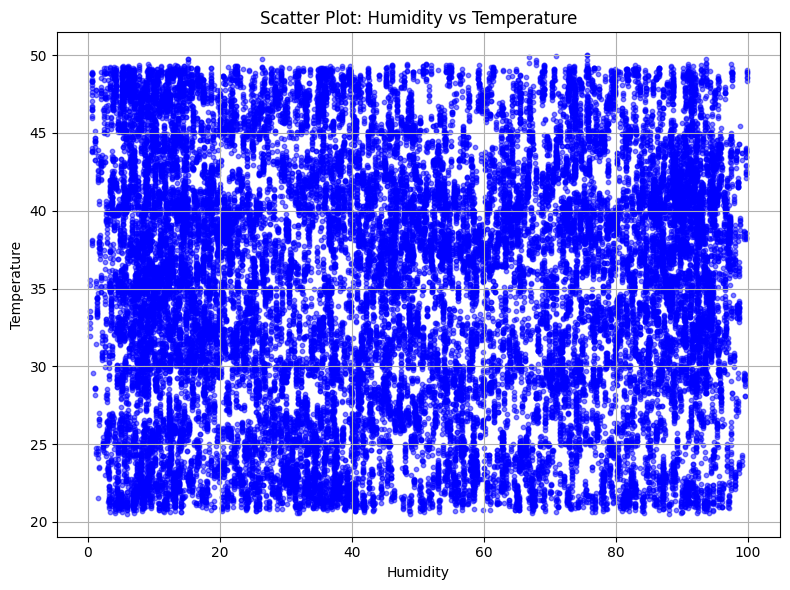

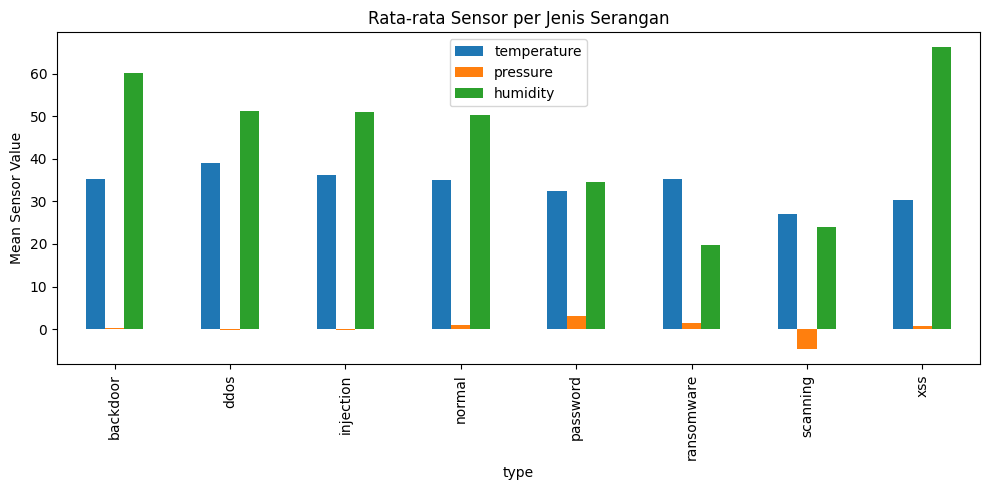

In [3]:
# ================================
# DATA EXPLORATION
# ================================

print("\n" + "="*50)
print("DATA EXPLORATION")
print("="*50)

# Cek tipe data
print("Data Types:")
print(df.dtypes)

# Statistik deskriptif untuk fitur numerik
print("\nDescriptive Statistics:")
print(df[['temperature', 'pressure', 'humidity']].describe())

# Distribusi label serangan
print(f"\nAttack type distribution:")
attack_distribution = df['type'].value_counts()
print(attack_distribution)

# Visualisasi distribusi jenis serangan
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
attack_distribution.plot(kind='bar', rot=45)
plt.title('Attack Type Distribution')
plt.xlabel('Attack Type')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
attack_distribution.plot(kind='pie', autopct='%1.1f%%')
plt.title('Attack Type Distribution (Percentage)')
plt.ylabel('')

plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'attack_type_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

# Scatter plot antara humidity dan temperature
plt.figure(figsize=(8, 6))
plt.scatter(df['humidity'], df['temperature'], c='blue', alpha=0.5, s=10)
plt.title('Scatter Plot: Humidity vs Temperature')
plt.xlabel('Humidity')
plt.ylabel('Temperature')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'humidity_vs_temperature.png'), dpi=300, bbox_inches='tight')
plt.show()

# Analisis hubungan antara serangan dan rata-rata nilai sensor
sensor_mean_by_type = df.groupby('type')[['temperature', 'pressure', 'humidity']].mean()
sensor_mean_by_type.plot(kind='bar', figsize=(10, 5))
plt.title('Rata-rata Sensor per Jenis Serangan')
plt.ylabel('Mean Sensor Value')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'sensor_mean_by_type.png'), dpi=300, bbox_inches='tight')
plt.show()

In [4]:
# Implementasi Kalman Filter
def apply_kalman_filter(signal_data):
    if hasattr(signal_data, 'values'):
        signal_array = signal_data.values
    else:
        signal_array = np.array(signal_data)
    observations = signal_array.reshape(-1, 1)
    kf = KalmanFilter(
        transition_matrices=np.array([[1, 1], [0, 1]]),
        observation_matrices=np.array([[1, 0]]),
        initial_state_mean=np.array([signal_array[0], 0]),
        initial_state_covariance=np.eye(2),
        observation_covariance=np.array([[1.0]]),
        transition_covariance=np.array([[0.1, 0], [0, 0.1]]),
        n_dim_state=2
    )
    kf_fitted = kf.em(observations, n_iter=10)
    state_means, _ = kf_fitted.smooth(observations)
    return state_means[:, 0]

In [5]:
df_filtered = df.copy()
df_filtered['temperature'] = apply_kalman_filter(df['temperature'])
df_filtered['pressure'] = apply_kalman_filter(df['pressure'])
df_filtered['humidity'] = apply_kalman_filter(df['humidity'])

In [6]:
# ================================
# FEATURE ENGINEERING 
# ================================

print("\n" + "="*50)
print("FEATURE ENGINEERING")
print("="*50)

df_processed = df_filtered.copy()

# Gabungkan kolom date dan time menjadi datetime
df_processed['datetime'] = pd.to_datetime(
    df_processed['date'].str.strip() + ' ' + df_processed['time'].str.strip(),
    format='%d-%b-%y %H:%M:%S',
    errors='coerce'
)

# Urutkan berdasarkan waktu
df_processed = df_processed.sort_values('datetime').reset_index(drop=True)
df_processed['group_id'] = df_processed['datetime'].dt.floor('T')  # per menit

# Ekstraksi fitur waktu
df_processed['hour']        = df_processed['datetime'].dt.hour
df_processed['minute']      = df_processed['datetime'].dt.minute
df_processed['second']      = df_processed['datetime'].dt.second
df_processed['day_of_week'] = df_processed['datetime'].dt.dayofweek
df_processed['is_weekend']  = (df_processed['day_of_week'] >= 5).astype(int)
df_processed['hour_sin']    = np.sin(2*np.pi*df_processed['hour']/24)
df_processed['hour_cos']    = np.cos(2*np.pi*df_processed['hour']/24)
df_processed['min_sin']     = np.sin(2*np.pi*df_processed['minute']/60)
df_processed['min_cos']     = np.cos(2*np.pi*df_processed['minute']/60)

# Selisih waktu antar baris (dalam detik)
df_processed['time_diff'] = df_processed['datetime'].diff().dt.total_seconds().fillna(0)

# ============================================
# Temperature Dynamics Features (Sensor Basis)
# ============================================
win = 10  # ukuran jendela rolling

df_processed['temp_roll_mean'] = df_processed['temperature'].rolling(window=win, min_periods=1).mean()
df_processed['temp_roll_std'] = df_processed['temperature'].rolling(window=win, min_periods=1).std().fillna(0)
df_processed['temp_roll_range'] = (
    df_processed['temperature'].rolling(window=win, min_periods=1).max() -
    df_processed['temperature'].rolling(window=win, min_periods=1).min()
)

# Perubahan suhu
df_processed['temp_diff'] = df_processed['temperature'].diff().fillna(0)
df_processed['temp_velocity'] = df_processed['temp_diff'] / df_processed['time_diff'].replace(0, 1e-6)
df_processed['temp_acceleration'] = df_processed['temp_velocity'].diff().fillna(0) / df_processed['time_diff'].replace(0, 1e-6)

# Deteksi stabilitas
df_processed['temp_zscore'] = (df_processed['temperature'] - df_processed['temp_roll_mean']) / df_processed['temp_roll_std'].replace(0, 1e-6)
df_processed['is_temp_anomaly'] = (np.abs(df_processed['temp_zscore']) > 3).astype(int)

# ============================================
# Advanced Signal Features (Suhu)
# ============================================
def dominant_freq(arr, sr=1.0):
    if len(arr) < 3:
        return 0.0
    yf = np.abs(rfft(arr - np.mean(arr)))
    xf = rfftfreq(len(arr), d=1/sr)
    if len(yf) < 2:
        return 0.0
    idx = np.argmax(yf[1:]) + 1
    return xf[idx]

def signal_entropy(arr):
    if len(arr) < 2:
        return 0.0
    hist, _ = np.histogram(arr, bins=10, density=True)
    hist = hist[hist > 0]
    return entropy(hist)

df_processed['temp_dom_freq'] = df_processed['temperature'].rolling(window=win, min_periods=3).apply(lambda x: dominant_freq(x.values, sr=1), raw=False).fillna(0)
df_processed['temp_entropy'] = df_processed['temperature'].rolling(window=win, min_periods=2).apply(signal_entropy, raw=False).fillna(0)

# ============================================
# Interaction Features (Pressure & Humidity)
# ============================================
df_processed['pressure_x_humidity'] = df_processed['pressure'] * df_processed['humidity']
df_processed['temp_x_pressure'] = df_processed['temperature'] * df_processed['pressure']
df_processed['temp_x_humidity'] = df_processed['temperature'] * df_processed['humidity']

# ============================================
# Summary
# ============================================
new_features = [col for col in df_processed.columns if col not in df_filtered.columns]
print(f"Added {len(new_features)} new features: {new_features}")


FEATURE ENGINEERING
Added 25 new features: ['datetime', 'group_id', 'hour', 'minute', 'second', 'day_of_week', 'is_weekend', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos', 'time_diff', 'temp_roll_mean', 'temp_roll_std', 'temp_roll_range', 'temp_diff', 'temp_velocity', 'temp_acceleration', 'temp_zscore', 'is_temp_anomaly', 'temp_dom_freq', 'temp_entropy', 'pressure_x_humidity', 'temp_x_pressure', 'temp_x_humidity']


In [7]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39260 entries, 0 to 39259
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 39260 non-null  object        
 1   time                 39260 non-null  object        
 2   temperature          39260 non-null  float64       
 3   pressure             39260 non-null  float64       
 4   humidity             39260 non-null  float64       
 5   label                39260 non-null  int64         
 6   type                 39260 non-null  object        
 7   datetime             39260 non-null  datetime64[ns]
 8   group_id             39260 non-null  datetime64[ns]
 9   hour                 39260 non-null  int32         
 10  minute               39260 non-null  int32         
 11  second               39260 non-null  int32         
 12  day_of_week          39260 non-null  int32         
 13  is_weekend           39260 non-

In [8]:
# ================================
# IDENTIFYING MISSING VALUES
# ================================

print("\n" + "="*50)
print("MISSING VALUES ANALYSIS")
print("="*50)

# Check for missing values
missing_values = df_processed.isnull().sum()
missing_percentage = (missing_values / len(df_processed)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
})

print("Missing values summary:")
print(missing_df[missing_df['Missing Count'] > 0])

# Visualize missing values if any
if missing_values.sum() > 0:
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_processed.isnull(), cbar=True, yticklabels=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.savefig(os.path.join(viz_dir, 'missing_values_heatmap.png'), dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No missing values found in the dataset!")


MISSING VALUES ANALYSIS
Missing values summary:
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []
No missing values found in the dataset!


In [9]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39260 entries, 0 to 39259
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 39260 non-null  object        
 1   time                 39260 non-null  object        
 2   temperature          39260 non-null  float64       
 3   pressure             39260 non-null  float64       
 4   humidity             39260 non-null  float64       
 5   label                39260 non-null  int64         
 6   type                 39260 non-null  object        
 7   datetime             39260 non-null  datetime64[ns]
 8   group_id             39260 non-null  datetime64[ns]
 9   hour                 39260 non-null  int32         
 10  minute               39260 non-null  int32         
 11  second               39260 non-null  int32         
 12  day_of_week          39260 non-null  int32         
 13  is_weekend           39260 non-

In [10]:
# ----- STEP 1: Siapkan data -----
X_all = df_processed.copy()
X_all.drop(['date','time','datetime', 'group_id', 'type', 'label'], axis=1, inplace=True)
y_all = df_processed['type'].copy()
groups_all = df_processed['group_id']

# ----- STEP 2: Fungsi bantu untuk menghitung distribusi label -----
def get_label_distribution(y):
    dist = y.value_counts(normalize=True).sort_index()
    return dist

# ----- STEP 3: Cari split dengan distribusi label terbaik -----
best_split = None
lowest_diff_score = float('inf')

n_trials = 10  # jumlah percobaan

for trial in range(n_trials):
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=trial)

    for train_idx, temp_idx in sgkf.split(X_all, y_all, groups=groups_all):
        # Split awal: Train (70%), Temp (30%)
        X_train = X_all.iloc[train_idx]
        y_train = y_all.iloc[train_idx]
        groups_train = groups_all.iloc[train_idx]

        X_temp = X_all.iloc[temp_idx]
        y_temp = y_all.iloc[temp_idx]
        groups_temp = groups_all.iloc[temp_idx]

        # Dari Temp, split lagi jadi val/test (masing-masing 15%)
        sgkf_inner = StratifiedGroupKFold(n_splits=2, shuffle=True, random_state=trial)

        for val_idx, test_idx in sgkf_inner.split(X_temp, y_temp, groups=groups_temp):
            X_val = X_temp.iloc[val_idx]
            y_val = y_temp.iloc[val_idx]

            X_test = X_temp.iloc[test_idx]
            y_test = y_temp.iloc[test_idx]

            # Hitung distribusi label dan perbedaannya
            dist_train = get_label_distribution(y_train)
            dist_val = get_label_distribution(y_val)
            dist_test = get_label_distribution(y_test)

            # Gabungkan dan hitung error
            labels_all = sorted(list(set(y_all)))
            dist_train = dist_train.reindex(labels_all, fill_value=0)
            dist_val = dist_val.reindex(labels_all, fill_value=0)
            dist_test = dist_test.reindex(labels_all, fill_value=0)

            diff_score = mean_squared_error(dist_train, dist_val) + mean_squared_error(dist_train, dist_test)

            if diff_score < lowest_diff_score:
                lowest_diff_score = diff_score
                best_split = {
                    "X_train": X_train, "y_train": y_train,
                    "X_val": X_val, "y_val": y_val,
                    "X_test": X_test, "y_test": y_test
                }

            break  # hanya ambil satu val/test split dari 2-fold
    print(f"Percobaan {trial+1} selesai. Skor distribusi: {lowest_diff_score:.5f}")

# ----- STEP 4: Ambil hasil split terbaik -----
X_train_best = best_split["X_train"]
y_train_best = best_split["y_train"]
X_val_best = best_split["X_val"]
y_val_best = best_split["y_val"]
X_test_best = best_split["X_test"]
y_test_best = best_split["y_test"]

# ----- STEP 5: Tampilkan distribusi label terbaik -----
print("\nDistribusi label terbaik:")
for name, y_part in zip(['Train', 'Val', 'Test'], [y_train_best, y_val_best, y_test_best]):
    print(f"\n{name}:\n", y_part.value_counts(normalize=True).sort_index().apply(lambda x: f"{x:.2%}"))

Percobaan 1 selesai. Skor distribusi: 0.01772
Percobaan 2 selesai. Skor distribusi: 0.01772
Percobaan 3 selesai. Skor distribusi: 0.01772
Percobaan 4 selesai. Skor distribusi: 0.01772
Percobaan 5 selesai. Skor distribusi: 0.01772
Percobaan 6 selesai. Skor distribusi: 0.01050
Percobaan 7 selesai. Skor distribusi: 0.01050
Percobaan 8 selesai. Skor distribusi: 0.00513
Percobaan 9 selesai. Skor distribusi: 0.00513
Percobaan 10 selesai. Skor distribusi: 0.00513

Distribusi label terbaik:

Train:
 type
backdoor      13.25%
ddos          13.75%
injection     11.96%
normal        36.22%
password      13.06%
ransomware     8.06%
scanning       1.44%
xss            2.27%
Name: proportion, dtype: object

Val:
 type
backdoor      11.61%
ddos           6.40%
injection     21.93%
normal        39.53%
password      13.05%
ransomware     4.85%
scanning       0.74%
xss            1.89%
Name: proportion, dtype: object

Test:
 type
backdoor      10.42%
ddos          12.16%
injection      8.95%
normal    

In [11]:
def show_label_distribution(y_train, y_val, y_test, label_name='type'):
    # Buat dataframe dari label
    dist_df = pd.DataFrame({
        'train': y_train.value_counts(normalize=False),
        'val': y_val.value_counts(normalize=False),
        'test': y_test.value_counts(normalize=False)
    }).fillna(0).astype(int)

    dist_df_percent = pd.DataFrame({
        'train': y_train.value_counts(normalize=True) * 100,
        'val': y_val.value_counts(normalize=True) * 100,
        'test': y_test.value_counts(normalize=True) * 100
    }).fillna(0).round(2)

    # Tampilkan distribusi dalam bentuk tabel
    print("Distribusi Label (Jumlah):\n", dist_df)
    print("\nDistribusi Label (Persentase):\n", dist_df_percent)

    # Plot jumlah label
    dist_df.plot(kind='bar', figsize=(10, 6), colormap='viridis')
    plt.title(f'Distribusi Label {label_name.upper()} - Jumlah')
    plt.xlabel('Label')
    plt.ylabel('Jumlah')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # Plot persentase label
    dist_df_percent.plot(kind='bar', figsize=(10, 6), colormap='Set2')
    plt.title(f'Distribusi Label {label_name.upper()} - Persentase')
    plt.xlabel('Label')
    plt.ylabel('Persentase (%)')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

Distribusi Label (Jumlah):
             train   val  test
type                         
backdoor     4010   515   475
ddos         4162   284   554
injection    3619   973   408
normal      10962  1754  2284
password     3952   579   469
ransomware   2439   215   211
scanning      435    33    61
xss           687    84    95

Distribusi Label (Persentase):
             train    val   test
type                           
backdoor    13.25  11.61  10.42
ddos        13.75   6.40  12.16
injection   11.96  21.93   8.95
normal      36.22  39.53  50.12
password    13.06  13.05  10.29
ransomware   8.06   4.85   4.63
scanning     1.44   0.74   1.34
xss          2.27   1.89   2.08


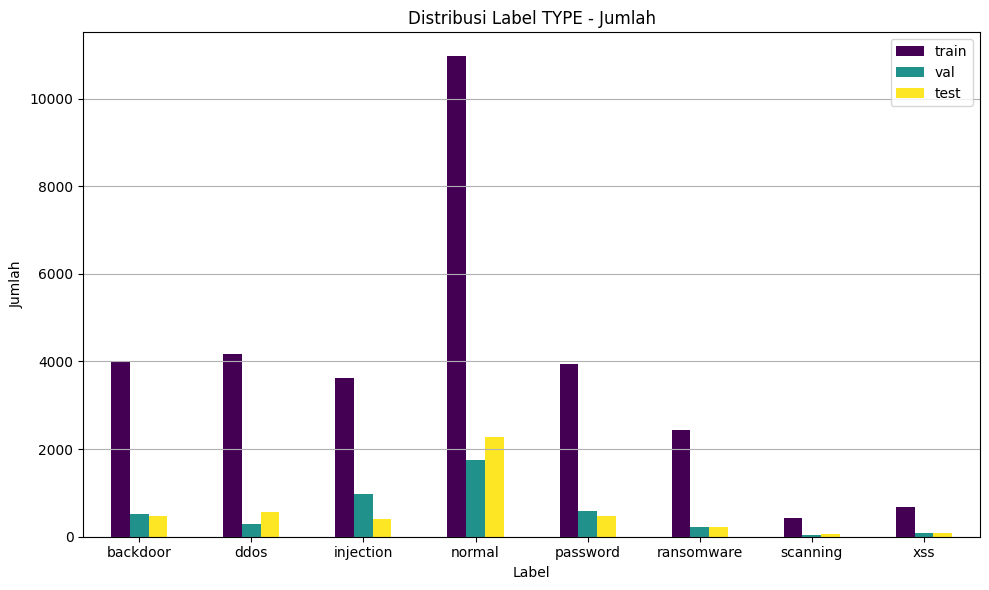

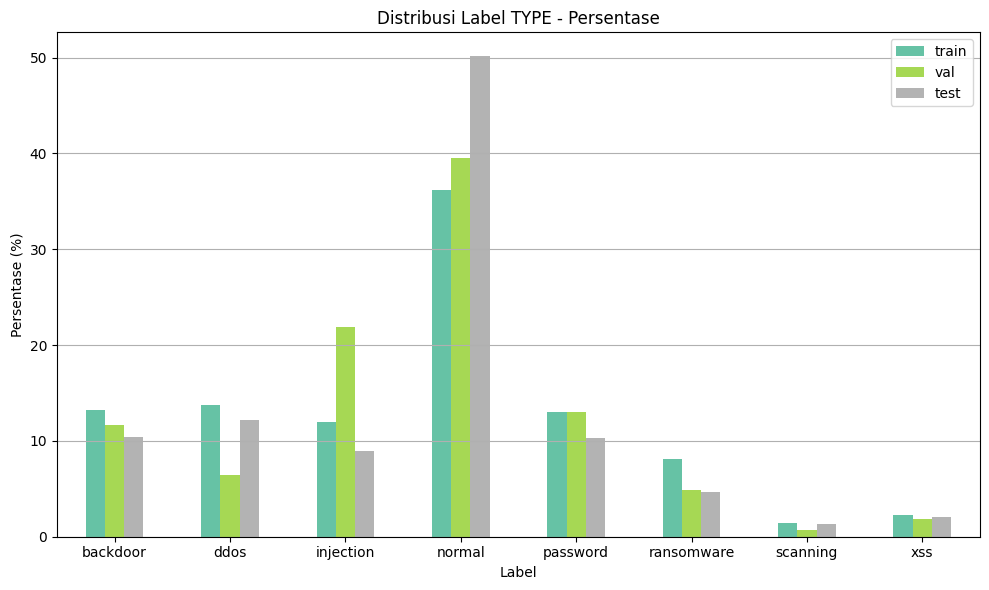

In [12]:
show_label_distribution(y_train_best, y_val_best, y_test_best, label_name='type')

In [13]:
# ================================
# SIMPLE IMPUTER AND MINMAX SCALER
# ================================

print("\n" + "="*50)
print("DATA PREPROCESSING - IMPUTATION AND SCALING")
print("="*50)

# Handle any remaining missing values with SimpleImputer
imputer = SimpleImputer(strategy='median')
# X_imputed_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
# X_imputed_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
# X_imputed_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# print(f"Features shape train after imputation: {X_imputed_train.shape}")
# print(f"Features shape val after imputation: {X_imputed_val.shape}")
# print(f"Features shape test after imputation: {X_imputed_test.shape}")

# Apply MinMax Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_best)
X_val_scaled = scaler.transform(X_val_best)
X_test_scaled = scaler.transform(X_test_best)

print("Data scaling completed!")
print(f"Scaled features train shape: {X_train_scaled.shape}")
print(f"Scaled features val shape: {X_val_scaled.shape}")
print(f"Scaled features test shape: {X_test_scaled.shape}")



# Save preprocessors
with open(os.path.join(artifacts_dir, 'imputer.pkl'), 'wb') as f:
    pickle.dump(imputer, f)

with open(os.path.join(artifacts_dir, 'minmax.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

print(f"Imputer saved to {artifacts_dir}/imputer.pkl")
print(f"Scaler saved to {artifacts_dir}/minmax.pkl")

# Encode target labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_best)
y_val_encoded = le.transform(y_val_best)
y_test_encoded = le.transform(y_test_best)

# Save target label encoder
with open(os.path.join(artifacts_dir, 'label_encoder_target.pkl'), 'wb') as f:
    pickle.dump(le, f)

print(f"Target classes: {le.classes_}")
print(f"Target train shape: {y_train_encoded.shape}")
print(f"Target val shape: {y_val_encoded.shape}")
print(f"Target test shape: {y_test_encoded.shape}")
print(f"Target label encoder saved to {artifacts_dir}/label_encoder_target.pkl")


DATA PREPROCESSING - IMPUTATION AND SCALING
Data scaling completed!
Scaled features train shape: (30266, 26)
Scaled features val shape: (4437, 26)
Scaled features test shape: (4557, 26)
Imputer saved to artifacts/imputer.pkl
Scaler saved to artifacts/minmax.pkl
Target classes: ['backdoor' 'ddos' 'injection' 'normal' 'password' 'ransomware' 'scanning'
 'xss']
Target train shape: (30266,)
Target val shape: (4437,)
Target test shape: (4557,)
Target label encoder saved to artifacts/label_encoder_target.pkl


In [14]:
y_train_cat = to_categorical(y_train_encoded)
y_val_cat = to_categorical(y_val_encoded)
y_test_cat = to_categorical(y_test_encoded)

In [15]:
print(X_train_scaled.shape)
print('\n',X_train_scaled[:5])
print('\n',X_val_scaled.shape)
print('\n',X_val_scaled[:5])
print('\n',X_test_scaled.shape)
print('\n',X_test_scaled[:5])
print('\n',y_train_encoded.shape)
print('\n',y_train_encoded[:10])
print('\n',y_val_encoded.shape)
print('\n',y_val_encoded[:10])
print('\n',y_test_encoded.shape)
print('\n',y_test_encoded[:10])
print('\n',y_train_cat.shape)
print('\n',y_train_cat[:10])
print('\n',y_val_cat.shape)
print('\n',y_val_cat[:10])
print('\n',y_test_cat.shape)
print('\n',y_test_cat[:10])

(30266, 26)

 [[5.92972637e-01 6.19854077e-01 5.29456709e-01 4.50000000e-01
  6.94915254e-01 0.00000000e+00 1.00000000e+00 1.00000000e+00
  4.91333810e-01 0.00000000e+00 4.32272712e-02 2.96631678e-01
  4.96384583e-07 4.27503105e-01 3.20120703e-01 4.45431220e-01
  7.51428642e-01 5.00751758e-01 4.56198195e-01 9.42381573e-01
  0.00000000e+00 5.00000000e-01 2.41079680e-01 5.14418293e-01
  5.95488561e-01 4.60817986e-01]
 [5.65836208e-01 6.22006207e-01 3.84237825e-01 4.50000000e-01
  6.94915254e-01 0.00000000e+00 1.00000000e+00 1.00000000e+00
  4.91333810e-01 0.00000000e+00 4.32272712e-02 2.96631678e-01
  0.00000000e+00 4.44931992e-01 3.77702545e-01 4.45431220e-01
  4.35056234e-01 4.59451077e-01 4.33738812e-01 7.75171108e-01
  0.00000000e+00 2.50000000e-01 3.86253443e-01 4.95560262e-01
  5.96185523e-01 3.29732308e-01]
 [5.70984953e-01 6.22997181e-01 3.86730838e-01 4.50000000e-01
  6.94915254e-01 0.00000000e+00 1.00000000e+00 1.00000000e+00
  4.91333810e-01 0.00000000e+00 4.32272712e-02 2.966

In [16]:
# ================================
# SELEKSI FITUR GA
# ================================

# ========================================
# =========== PARAMETER & INPUT ==========
# ========================================
POP_SIZE = 20
N_GENERATIONS = 15
MUTATION_RATE = 0.2
TOURNAMENT_SIZE = 3
FEATURE_COUNT = X_train_scaled.shape[1]
N_CLASSES = y_train_cat.shape[1]

y_train_labels = np.argmax(y_train_cat, axis=1)
y_val_labels = np.argmax(y_val_cat, axis=1)

# =============================
# === CLASS WEIGHT OTOMATIS ===
# =============================
class_weight_values = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights = {i: w for i, w in enumerate(class_weight_values)}
print("Class weights:", class_weights)

# ========================================
# ========== MODEL LSTM SEDERHANA ========
# ========================================
def create_lstm_model(input_shape, n_classes):
    model = Sequential()
    model.add(LSTM(64, return_sequences=False, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])
    return model

# ========================
# === FITNESS FUNCTION ===
# ========================
def fitness(individual):
    if sum(individual) == 0:
        return 0.0,

    selected_features = [i for i, bit in enumerate(individual) if bit == 1]

    # Subset data
    X_train_sub = X_train_scaled[:, selected_features]
    X_val_sub = X_val_scaled[:, selected_features]

    # Reshape untuk LSTM
    X_train_sub = X_train_sub.reshape((X_train_sub.shape[0], 1, X_train_sub.shape[1]))
    X_val_sub = X_val_sub.reshape((X_val_sub.shape[0], 1, X_val_sub.shape[1]))

    # Buat model dan latih
    model = create_lstm_model(input_shape=(1, len(selected_features)), n_classes=N_CLASSES)
    model.fit(X_train_sub, y_train_cat, epochs=3, batch_size=64, verbose=0, class_weight=class_weights)

    # Evaluasi
    y_pred = np.argmax(model.predict(X_val_sub, verbose=0), axis=1)

    # Hitung F1 Macro dengan bobot kelas
    f1_per_class = f1_score(y_val_labels, y_pred, average=None)
    weights = np.array([class_weights.get(i, 1.0) for i in range(len(f1_per_class))])
    weighted_f1 = np.average(f1_per_class, weights=weights)

    return weighted_f1,

# ===========================
# === TOOLS UNTUK GA ===
# ===========================
def init_population():
    return [np.random.randint(0, 2, FEATURE_COUNT).tolist() for _ in range(POP_SIZE)]

def tournament_selection(pop, fitnesses):
    selected = random.sample(list(zip(pop, fitnesses)), TOURNAMENT_SIZE)
    selected = sorted(selected, key=lambda x: x[1][0], reverse=True)
    return selected[0][0]

def crossover(parent1, parent2):
    point = random.randint(1, FEATURE_COUNT - 1)
    return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

def mutate(individual):
    for i in range(FEATURE_COUNT):
        if random.random() < MUTATION_RATE:
            individual[i] = 1 - individual[i]

# ==========================
# === MAIN LOOP GA ===
# ==========================
population = init_population()
fitnesses = [fitness(ind) for ind in population]

for gen in range(N_GENERATIONS):
    print(f'\nGeneration {gen + 1}/{N_GENERATIONS}')
    f1s = [fit[0] for fit in fitnesses]
    print(f' Best fitness: {max(f1s):.4f} | Avg fitness: {np.mean(f1s):.4f}')

    new_population = []
    while len(new_population) < POP_SIZE:
        p1 = tournament_selection(population, fitnesses)
        p2 = tournament_selection(population, fitnesses)
        c1, c2 = crossover(p1, p2)
        mutate(c1)
        mutate(c2)
        new_population.extend([c1, c2])

    population = new_population[:POP_SIZE]
    fitnesses = [fitness(ind) for ind in population]

# ===========================
# === OUTPUT AKHIR GA ===
# ===========================
f1s = [fit[0] for fit in fitnesses]
best_idx = np.argmax(f1s)
best_individual = population[best_idx]
selected_features = [i for i, bit in enumerate(best_individual) if bit == 1]

print("\n=== HASIL SELEKSI FITUR GA DENGAN CLASS WEIGHT ===")
print("Indeks Fitur Terpilih:", selected_features)
print("Jumlah Fitur Terpilih:", len(selected_features))
print("Best Fitness (Weighted F1 Macro): {:.4f}".format(f1s[best_idx]))

Class weights: {0: 0.9434538653366583, 1: 0.9089980778471889, 2: 1.0453854655982315, 3: 0.34512406495165115, 4: 0.9573001012145749, 5: 1.5511480114801148, 6: 8.697126436781609, 7: 5.506914119359534}

Generation 1/15
 Best fitness: 0.9998 | Avg fitness: 0.9156

Generation 2/15
 Best fitness: 1.0000 | Avg fitness: 0.9528

Generation 3/15
 Best fitness: 1.0000 | Avg fitness: 0.9462

Generation 4/15
 Best fitness: 1.0000 | Avg fitness: 0.9659

Generation 5/15
 Best fitness: 1.0000 | Avg fitness: 0.9937

Generation 6/15
 Best fitness: 1.0000 | Avg fitness: 0.9784

Generation 7/15
 Best fitness: 1.0000 | Avg fitness: 0.9411

Generation 8/15
 Best fitness: 1.0000 | Avg fitness: 0.9877

Generation 9/15
 Best fitness: 1.0000 | Avg fitness: 0.9849

Generation 10/15
 Best fitness: 1.0000 | Avg fitness: 0.9920

Generation 11/15
 Best fitness: 1.0000 | Avg fitness: 0.9633

Generation 12/15
 Best fitness: 1.0000 | Avg fitness: 0.9652

Generation 13/15
 Best fitness: 1.0000 | Avg fitness: 0.9527

Gen

In [22]:
feature_names = X_all.columns.tolist()

selected_feature_names = [feature_names[i] for i in selected_features]
print("Selected Feature Names:", selected_feature_names)

Selected Feature Names: ['humidity', 'hour', 'minute', 'second', 'day_of_week', 'is_weekend', 'min_sin', 'min_cos', 'temp_roll_mean', 'temp_roll_range', 'temp_velocity', 'temp_entropy', 'temp_x_pressure', 'temp_x_humidity']


In [23]:
X_train_selected = pd.DataFrame(X_train_scaled[:, selected_features], columns=[feature_names[i] for i in selected_features])
print(X_train_selected.shape)
print(X_train_selected.info())
print(X_train_selected.head())

(30266, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30266 entries, 0 to 30265
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   humidity         30266 non-null  float64
 1   hour             30266 non-null  float64
 2   minute           30266 non-null  float64
 3   second           30266 non-null  float64
 4   day_of_week      30266 non-null  float64
 5   is_weekend       30266 non-null  float64
 6   min_sin          30266 non-null  float64
 7   min_cos          30266 non-null  float64
 8   temp_roll_mean   30266 non-null  float64
 9   temp_roll_range  30266 non-null  float64
 10  temp_velocity    30266 non-null  float64
 11  temp_entropy     30266 non-null  float64
 12  temp_x_pressure  30266 non-null  float64
 13  temp_x_humidity  30266 non-null  float64
dtypes: float64(14)
memory usage: 3.2 MB
None
   humidity  hour    minute  second  day_of_week  is_weekend   min_sin  \
0  0.529457  0.45  0.69

In [24]:
X_val_selected = pd.DataFrame(X_val_scaled[:, selected_features], columns=[feature_names[i] for i in selected_features])
print(X_val_selected.shape)
print(X_val_selected.info())

(4437, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4437 entries, 0 to 4436
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   humidity         4437 non-null   float64
 1   hour             4437 non-null   float64
 2   minute           4437 non-null   float64
 3   second           4437 non-null   float64
 4   day_of_week      4437 non-null   float64
 5   is_weekend       4437 non-null   float64
 6   min_sin          4437 non-null   float64
 7   min_cos          4437 non-null   float64
 8   temp_roll_mean   4437 non-null   float64
 9   temp_roll_range  4437 non-null   float64
 10  temp_velocity    4437 non-null   float64
 11  temp_entropy     4437 non-null   float64
 12  temp_x_pressure  4437 non-null   float64
 13  temp_x_humidity  4437 non-null   float64
dtypes: float64(14)
memory usage: 485.4 KB
None


In [25]:
X_test_selected = pd.DataFrame(X_test_scaled[:, selected_features], columns=[feature_names[i] for i in selected_features])
print(X_test_selected.shape)
print(X_test_selected.info())

(4557, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4557 entries, 0 to 4556
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   humidity         4557 non-null   float64
 1   hour             4557 non-null   float64
 2   minute           4557 non-null   float64
 3   second           4557 non-null   float64
 4   day_of_week      4557 non-null   float64
 5   is_weekend       4557 non-null   float64
 6   min_sin          4557 non-null   float64
 7   min_cos          4557 non-null   float64
 8   temp_roll_mean   4557 non-null   float64
 9   temp_roll_range  4557 non-null   float64
 10  temp_velocity    4557 non-null   float64
 11  temp_entropy     4557 non-null   float64
 12  temp_x_pressure  4557 non-null   float64
 13  temp_x_humidity  4557 non-null   float64
dtypes: float64(14)
memory usage: 498.6 KB
None



CORRELATION ANALYSIS


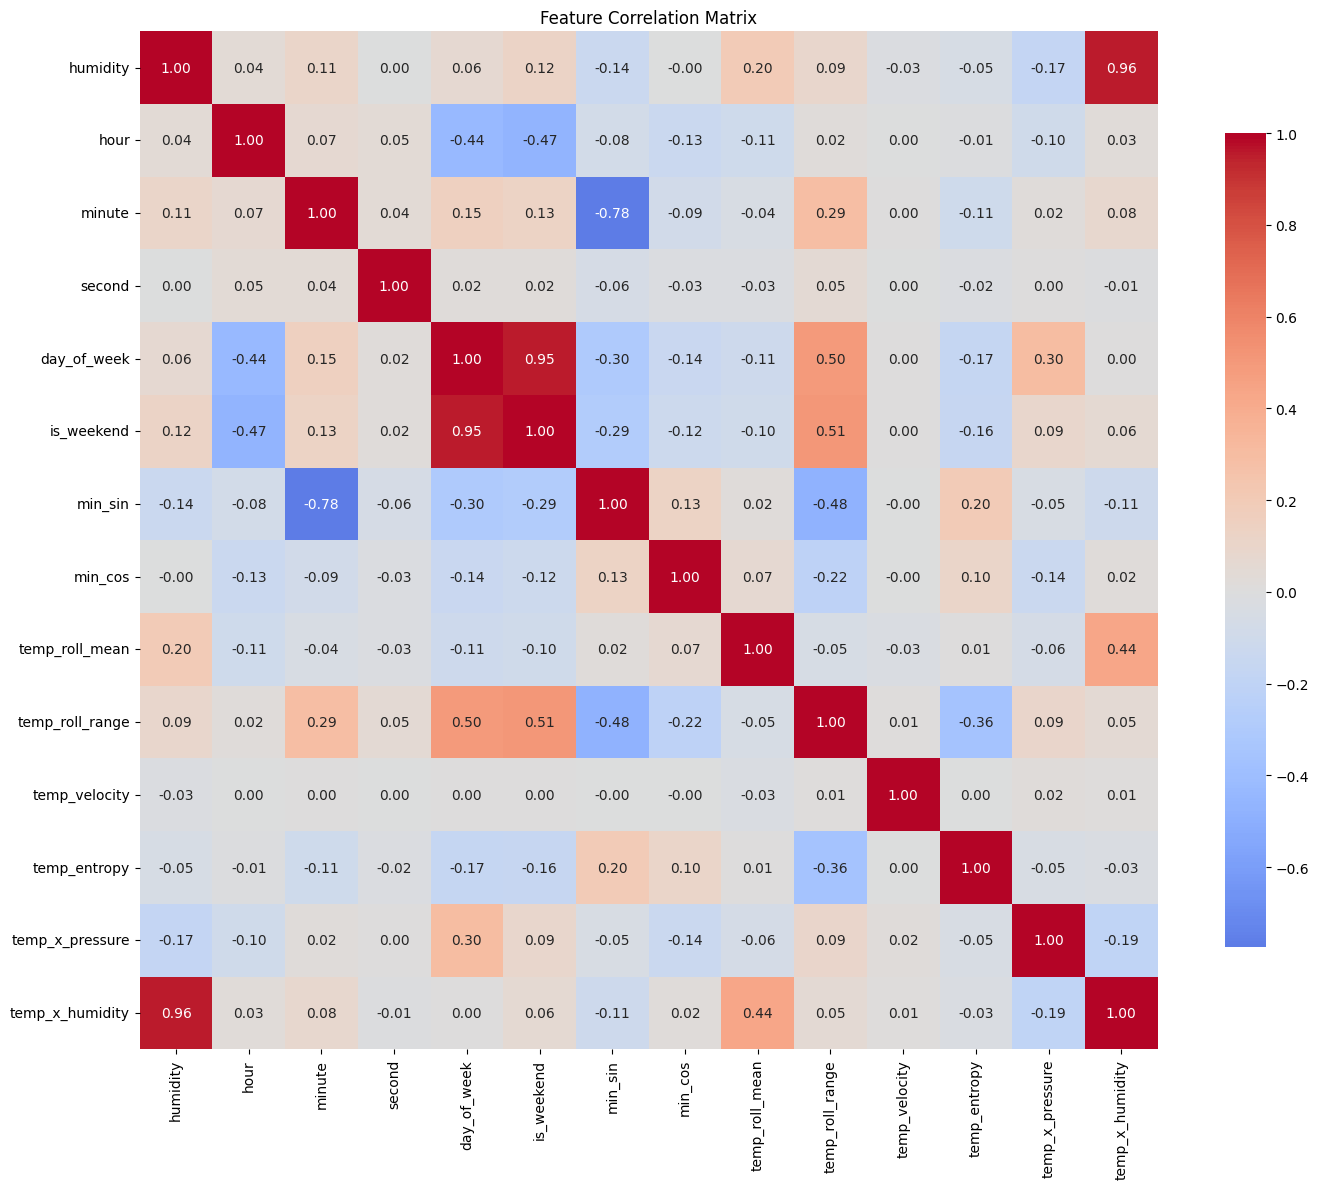

In [26]:
# ================================
# CORRELATION ANALYSIS
# ================================

print("\n" + "="*50)
print("CORRELATION ANALYSIS")
print("="*50)

# Calculate correlation matrix
correlation_matrix = X_train_selected.corr()

# Visualize correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'correlation_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

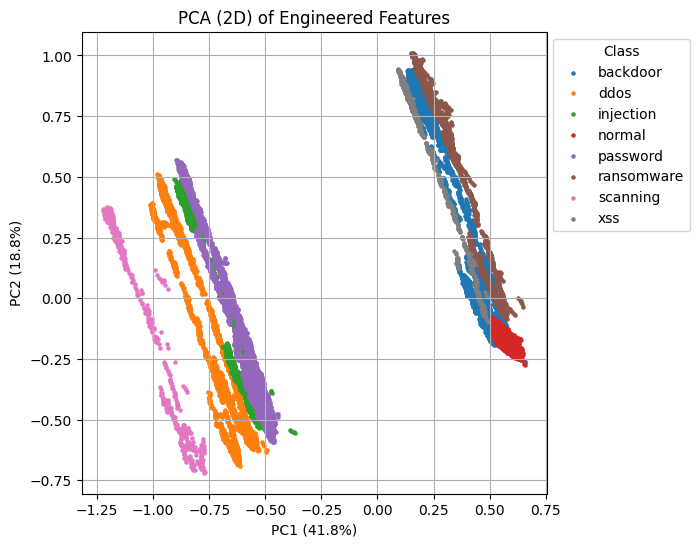

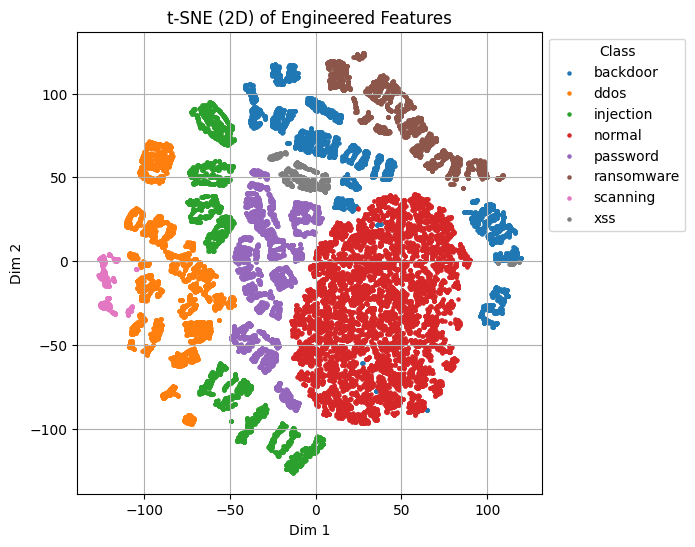

In [27]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_train_selected)

plt.figure(figsize=(6,6))
for cls in np.unique(y_train_best):
    idx = y_train_best == cls
    plt.scatter(X_pca[idx,0], X_pca[idx,1], s=5, label=str(cls))
plt.legend(title='Class', bbox_to_anchor=(1,1))
plt.title('PCA (2D) of Engineered Features')
plt.xlabel('PC1 (%.1f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC2 (%.1f%%)' % (pca.explained_variance_ratio_[1]*100))
plt.grid(True)
plt.savefig(os.path.join(viz_dir, 'PCA_engineering_feature.png'), dpi=300, bbox_inches='tight')
plt.show()

# 4) t-SNE → 2 dimensi (lebih lambat)
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_train_selected)  # pada seluruh dataset atau subset

plt.figure(figsize=(6,6))
for cls in np.unique(y_train_best):
    idx = y_train_best == cls
    plt.scatter(X_tsne[idx,0], X_tsne[idx,1], s=5, label=str(cls))
plt.legend(title='Class', bbox_to_anchor=(1,1))
plt.title('t-SNE (2D) of Engineered Features')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.grid(True)
plt.savefig(os.path.join(viz_dir, 'tSNE_2D_engineering_feature.png'), dpi=300, bbox_inches='tight')
plt.show()

In [28]:
tsne_3d = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42)
X_tsne_3d = tsne_3d.fit_transform(X_train_selected)

# 2) Buat DataFrame untuk Plotly
df_tsne = pd.DataFrame({
    'Dim1': X_tsne_3d[:, 0],
    'Dim2': X_tsne_3d[:, 1],
    'Dim3': X_tsne_3d[:, 2],
    'Class': y_train_best
})

# 3) Plot interaktif 3D
fig = px.scatter_3d(
    df_tsne,
    x='Dim1', y='Dim2', z='Dim3',
    color='Class',
    opacity=0.7,
    title='t-SNE (3D) of Engineered Features',
    width=900, height=700
)
fig.update_traces(marker=dict(size=4))
fig.update_layout(
    scene = dict(
        xaxis_title='Dim 1',
        yaxis_title='Dim 2',
        zaxis_title='Dim 3'
    ),
    legend_title='Class'
)

# 4) Simpan file HTML ke folder viz_dir
html_path = os.path.join(viz_dir, 'tsne_3d.html')
fig.write_html(html_path)

print(f"File HTML disimpan di: {html_path}")

# PCA ke dalam 3 dimensi
pca = PCA(n_components=3, random_state=42)
X_pca_3d = pca.fit_transform(X_train_selected)

# Buat DataFrame dari hasil PCA dan label
df_pca = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])
df_pca['label'] = y_train_best

# Visualisasi interaktif 3D menggunakan Plotly
fig = px.scatter_3d(
    df_pca, x='PC1', y='PC2', z='PC3',
    color='label',
    title='PCA (3D) of Engineered Features',
    labels={'label': 'Class'},
    opacity=0.7,
    width=800,
    height=600
)

# Simpan hasil visualisasi ke file HTML
output_html_path = os.path.join(viz_dir, 'PCA_3D.html')
fig.write_html(output_html_path)

File HTML disimpan di: visualization\tsne_3d.html


In [29]:
# Simpan ke file pickle
with open(os.path.join(artifacts_dir, 'data_train_preprocessing.pkl'), 'wb') as f:
    pickle.dump((X_train_selected, y_train_cat), f)
    
# Simpan ke file CSV
df_final = pd.DataFrame(X_train_selected)
df_final['type'] = np.array(y_train_encoded)

csv_path = os.path.join(artifacts_dir, 'data_train_preprocessing.csv')
df_final.to_csv(csv_path, index=False)

In [30]:
# Simpan ke file pickle
with open(os.path.join(artifacts_dir, 'data_val_preprocessing.pkl'), 'wb') as f:
    pickle.dump((X_val_selected, y_val_cat), f)
    
# Simpan ke file CSV
df_final = pd.DataFrame(X_val_selected)
df_final['type'] = np.array(y_val_encoded)

csv_path = os.path.join(artifacts_dir, 'data_val_preprocessing.csv')
df_final.to_csv(csv_path, index=False)

In [31]:
# Simpan ke file pickle
with open(os.path.join(artifacts_dir, 'data_test_preprocessing.pkl'), 'wb') as f:
    pickle.dump((X_test_selected, y_test_cat), f)
    
# Simpan ke file CSV
df_final = pd.DataFrame(X_test_selected)
df_final['type'] = np.array(y_test_encoded)

csv_path = os.path.join(artifacts_dir, 'data_test_preprocessing.csv')
df_final.to_csv(csv_path, index=False)